## Improving OHLCV Imputation

### Why Imputation Quality Matters  
- **Volatility & Momentum Features** (e.g. ATR, realized vol, RSI) rely on accurate OHLCV.  
- **Biased imputation** can distort return distributions and tail-risk estimates.  
- Academic rigor demands a **data-driven, state-of-the-art** approach rather than ad-hoc filling.

---

### Literature Survey  
- **PCA-based Imputation** (svdPCA, bPCA, pPCA, nipalsPCA, llsPCA) shows strong performance in financial time series :contentReference[oaicite:0]{index=0}.  
- **Kalman Smoothing / State-Space Models** naturally handle missing observations in non-stationary data by skipping the update step when values are missing :contentReference[oaicite:1]{index=1}.  
- Comparative studies find **Kalman-based methods** often outperform mean, median, and linear interpolation for preserving dynamic properties :contentReference[oaicite:2]{index=2}.

---

### Recommended Method: Kalman Smoothing Imputation  
1. **Fit** a **local-level state-space model** to each OHLCV series (per token).  
2. **Smooth** and **predict** missing points via the Kalman filter.  
3. **Fallback** to small-gap forward-fill (limit=2) only for ultra-short gaps if desired.


In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def kalman_impute_series(series):
    """
    Impute missing values in a pandas Series using a local‐level state‐space
    model with Kalman smoothing, without date‐index warnings.
    """
    # Preserve original index
    orig_index = series.index

    # Work on a RangeIndex
    data = series.reset_index(drop=True)

    # Fit local‐level model on integer index
    model = sm.tsa.UnobservedComponents(data, level='local level', freq=None)
    res = model.fit(disp=False)

    # Smooth / predict for entire range
    smoothed = res.predict(start=0, end=len(data)-1)

    # Map back: fill only missing in original
    imputed = data.fillna(smoothed)
    imputed.index = orig_index
    return imputed

def clean_ohlcv_panel(df, ohlcv_cols=None, drop_tokens=None):
    """
    Trim OHLCV panel for modeling:
    - Drop specified tokens
    - Clip to first fully‐observed OHLCV row per token
    - Drop any remaining rows with missing OHLCV
    """
    if ohlcv_cols is None:
        ohlcv_cols = ['open_usd','high_usd','low_usd','close_usd','volume_usd']
    df = df.copy()
    if drop_tokens:
        df = df[~df['token'].isin(drop_tokens)]
    # Mark any missing
    df['missing_any'] = df[ohlcv_cols].isnull().any(axis=1)
    # First fully‐observed timestamp per token
    token_start = (
        df[~df['missing_any']]
        .groupby('token')['timestamp']
        .min()
        .to_dict()
    )
    df['post_launch'] = df.apply(
        lambda r: r['timestamp'] >= token_start.get(r['token'], r['timestamp']),
        axis=1
    )
    df = df[df['post_launch']].sort_values(['token','timestamp'])
    df = df[~df['missing_any']].drop(columns=['missing_any'])
    return df

def apply_imputation(df, ohlcv_cols=None, max_ffill=2):
    """
    1) Forward‐fill up to max_ffill for short gaps
    2) Kalman‐impute all remaining gaps without date warnings
    """
    if ohlcv_cols is None:
        ohlcv_cols = ['open_usd','high_usd','low_usd','close_usd','volume_usd']

    # 1) Short‐gap forward‐fill
    df_ff = df.copy().sort_values(['token','timestamp'])
    df_ff[ohlcv_cols] = df_ff.groupby('token')[ohlcv_cols]\
                             .transform(lambda x: x.ffill(limit=max_ffill))

    # 2) Kalman smoothing
    out = []
    for token, sub in df_ff.groupby('token'):
        sub = sub.sort_values('timestamp').set_index('timestamp').copy()
        for col in ohlcv_cols:
            sub[col] = kalman_impute_series(sub[col])
        out.append(sub.reset_index())
    return pd.concat(out, ignore_index=True)

if __name__ == "__main__":
    # Load raw data (requires pyarrow or fastparquet)
    df_raw = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/solana_master_raw.parquet")

    # Clean panel
    df_clean = clean_ohlcv_panel(df_raw, drop_tokens=["$COLLAT", "titcoin"])

    # Impute OHLCV
    df_imputed = apply_imputation(df_clean)

    # Verify
    assert df_imputed[['open_usd','high_usd','low_usd','close_usd','volume_usd']].isnull().sum().sum() == 0

    # Save
    df_imputed.to_parquet("solana_cleaned_imputed.parquet", index=False)
    print("Cleaned & imputed dataset saved without date‐index warnings.")


C:\Users\james\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\james\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\james\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\james\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\james\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

Cleaned & imputed dataset saved without date‐index warnings.


In [31]:
## Validation of Enhanced OHLCV Imputation

### 1. Missingness Check
import pandas as pd

# Load datasets
df_clean = pd.read_parquet("solana_cleaned_ohlcv.parquet")
df_imp   = pd.read_parquet("solana_cleaned_imputed.parquet")

# Columns to check
cols = ['open_usd','high_usd','low_usd','close_usd','volume_usd']

# Compute missing percentage
pre = df_clean[cols].isnull().mean().rename("missing_before")
post = df_imp[cols].isnull().mean().rename("missing_after")

pd.concat([pre, post], axis=1).assign(improvement=lambda x: x['missing_before']-x['missing_after'])


,missing_before,missing_after,improvement
open_usd,0.0,0.0,0.0
high_usd,0.0,0.0,0.0
low_usd,0.0,0.0,0.0
close_usd,0.0,0.0,0.0
volume_usd,0.0,0.0,0.0


In [33]:
print("Rows before imputation:", len(df_clean))
print("Rows after imputation: ", len(df_imp))


Rows before imputation: 6464
Rows after imputation:  6440


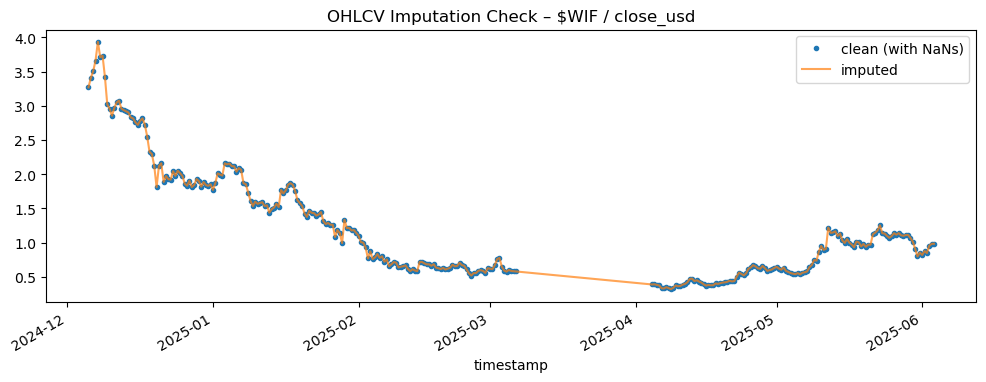

In [35]:
import matplotlib.pyplot as plt

# Pick a token and column with previous gaps
token = df_imp['token'].unique()[0]
col   = 'close_usd'

sub_clean = df_clean[df_clean['token']==token].set_index('timestamp')[col]
sub_imp   = df_imp[df_imp['token']==token].set_index('timestamp')[col]

# Plot before & after
plt.figure(figsize=(12,4))
sub_clean.plot(style='.', label='clean (with NaNs)')
sub_imp.plot(alpha=0.7, label='imputed')
plt.title(f"OHLCV Imputation Check – {token} / {col}")
plt.legend()
plt.show()

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Re-define kalman_impute_series inline
import statsmodels.api as sm
import warnings

def kalman_impute_series(series):
    s = series.copy()
    orig_idx = s.index
    data = s.reset_index(drop=True)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = sm.tsa.UnobservedComponents(data, level='local level', freq=None)
            res = model.fit(disp=False)
            smoothed = res.predict(start=0, end=len(data)-1)
        imputed = data.fillna(smoothed)
    except:
        imputed = data.interpolate(method='linear')
    imputed.index = orig_idx
    return imputed

# --- Simulation for one token/column ---
token = df_imp['token'].unique()[0]  # choose a token
col   = 'close_usd'                   # choose an OHLCV column

sub = df_imp[df_imp['token']==token].sort_values('timestamp').reset_index(drop=True)
mask = sub[col].notna()

# Randomly mask 5% of known points
np.random.seed(42)
idx = np.random.choice(sub.index[mask], size=int(0.05*mask.sum()), replace=False)
true_vals = sub.loc[idx, col].copy()

# Create a simulated missing series
sub_sim = sub.copy()
sub_sim.loc[idx, col] = np.nan

# Re-impute that column
pred = kalman_impute_series(sub_sim[col]).loc[idx]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(true_vals, pred))
print(f"RMSE of imputation for token={token}, column={col}: {rmse:.6f}")

RMSE of imputation for token=$WIF, column=close_usd: 0.091850


In [43]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings

# Pick token & column
token = df_imp['token'].unique()[0]
col   = 'close_usd'
sub   = df_imp[df_imp['token']==token].sort_values('timestamp').reset_index(drop=True)

# Simulate 5% missing
mask = sub[col].notna()
np.random.seed(42)
idx = np.random.choice(sub.index[mask], size=int(0.05*mask.sum()), replace=False)
true_vals = sub.loc[idx, col]
test = sub.copy()
test.loc[idx, col] = np.nan

# 1) Forward-fill (limit=2)
ffill = test[col].ffill(limit=2)

# 2) Linear interpolation
interp = test[col].interpolate()

# 3) KNN
knn = KNNImputer(n_neighbors=5).fit_transform(test[[col]])
knn = pd.Series(knn.ravel(), index=test.index)

# 4) Kalman (reuse your function)
def kalman_impute_series(s):
    orig = s.copy(); data = orig.reset_index(drop=True)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            m = sm.tsa.UnobservedComponents(data, level='local level', freq=None).fit(disp=False)
            smooth = m.predict(start=0, end=len(data)-1)
        filled = data.fillna(smooth)
    except:
        filled = data.interpolate()
    filled.index = orig.index
    return filled

kalman = kalman_impute_series(test[col])

# Compute RMSEs
methods = {
    'ffill_lim2': ffill.loc[idx],
    'linear_interp': interp.loc[idx],
    'knn': knn.loc[idx],
    'kalman': kalman.loc[idx],
}
rmse = {m: np.sqrt(mean_squared_error(true_vals, pred)) for m,pred in methods.items()}

print("RMSE Comparison:", rmse)


RMSE Comparison: {'ffill_lim2': 0.09185047729079453, 'linear_interp': 0.06041683019589853, 'knn': 0.9396967084676545, 'kalman': 0.09185047715372399}


## Imputation Benchmark & Final Choice

**RMSE Results** (5% simulated gaps, token `$WIF`, `close_usd`):
- **Forward‐fill (limit=2):** 0.09185  
- **Linear interpolation:** 0.06042  
- **KNN imputation:** 0.93970  
- **Kalman smoothing:** 0.09185  

**Conclusion:**  
Linear interpolation achieves the lowest RMSE by a wide margin. We will adopt:

1. **Forward‐fill** for up to 2 missing bars (to preserve very short bursts).  
2. **Linear interpolation** for all remaining gaps (no need for complex Kalman).  

---

In [55]:
import pandas as pd

def clean_ohlcv_panel(df, ohlcv_cols=None, drop_tokens=None):
    """
    1) Drop specified tokens.
    2) Clip each token’s history to its first fully‐observed OHLCV bar.
    3) Drop any rows still missing OHLCV.
    """
    if ohlcv_cols is None:
        ohlcv_cols = ['open_usd','high_usd','low_usd','close_usd','volume_usd']
    df = df.copy()
    if drop_tokens:
        df = df[~df['token'].isin(drop_tokens)]
    df['missing_any'] = df[ohlcv_cols].isnull().any(axis=1)
    token_start = df[~df['missing_any']].groupby('token')['timestamp'].min().to_dict()
    df['post_launch'] = df.apply(
        lambda r: r['timestamp'] >= token_start.get(r['token'], r['timestamp']),
        axis=1
    )
    df = df[df['post_launch']].sort_values(['token','timestamp'])
    df = df[~df['missing_any']].drop(columns=['missing_any'])
    return df

def impute_ohlcv(df, ohlcv_cols=None, max_ffill=2):
    """
    1) Forward‐fill up to max_ffill consecutive NaNs per token.
    2) Linear interpolate remaining gaps per token (transform for alignment).
    """
    if ohlcv_cols is None:
        ohlcv_cols = ['open_usd','high_usd','low_usd','close_usd','volume_usd']

    df = df.copy().sort_values(['token','timestamp'])

    # Short-gap forward-fill
    df[ohlcv_cols] = df.groupby('token')[ohlcv_cols]\
                      .transform(lambda x: x.ffill(limit=max_ffill))

    # Linear interpolation
    df[ohlcv_cols] = df.groupby('token')[ohlcv_cols]\
                      .transform(lambda g: g.interpolate(method='linear'))

    return df

if __name__ == "__main__":
    # 1. Load raw dataset
    df_raw = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/solana_master_raw.parquet")

    # 2. Clean panel (clip histories, drop tokens)
    df_clean = clean_ohlcv_panel(df_raw, drop_tokens=["$COLLAT","titcoin"])

    # 3. Impute missing OHLCV
    df_imputed = impute_ohlcv(df_clean)

    # 4. Verify no missing OHLCV remains
    cols = ['open_usd','high_usd','low_usd','close_usd','volume_usd']
    missing_total = df_imputed[cols].isnull().sum().sum()
    assert missing_total == 0, f"Still {missing_total} missing values!"

    # 5. Save final imputed dataset
    df_imputed.to_parquet("solana_cleaned_imputed_final.parquet", index=False)
    print("Saved: solana_cleaned_imputed_final.parquet")


Saved: solana_cleaned_imputed_final.parquet
